In [14]:
%matplotlib inline
# Import libraries
from torch import nn,cuda,backends, optim, save, load, no_grad
import torch
from torchvision.datasets import ImageFolder, CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time
import pandas as pd
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
from IPython import display
from torchvision.models import vgg19
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA

In [2]:
# Image transformations
#mean=[0.6870, 0.5849, 0.5098]
#std=[0.2588, 0.3198, 0.3642]

mean=[0.4914, 0.4822, 0.4465]
std=[0.2023, 0.1994, 0.2010]

transformations=transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomInvert(p=0.2),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.Normalize(mean=mean,std=std),
    ])

In [3]:
batch_size=35
data_train = CIFAR10(root='./data', train=True, download=True, transform=transformations)
dataloader_train = torch.utils.data.DataLoader(data_train,batch_size=batch_size, shuffle=True, num_workers=2)

data_test = CIFAR10(root='./data', train=False, download=True, transform=transformations)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Get device for pytorch to run on
device = (
    "cuda"
    if cuda.is_available()
    else "mps"
    if backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [5]:
class PrintLayer(nn.Module):
    def __init__(self,debug=""):
        super(PrintLayer, self).__init__()
        self.debug=debug
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(self.debug,": ",x.shape)
        return x

In [72]:
# Encoder
class Encoder(nn.Module):
    def __init__(self,bottleneck=9*9,dropout_percent=0.125):
        super().__init__()
        relu=nn.ReLU()
        dropout=nn.Dropout(p=dropout_percent)
        self.flatten=nn.Flatten()
        printL=PrintLayer()
        self.dropout_relu=nn.Sequential(
            dropout,
            relu,
        )
        self.conv_stack1=nn.Sequential(
            nn.Conv2d(3,1500,2,padding=1),
            nn.MaxPool2d(2,2,padding=1),
            #printL,
        )
        self.conv_stack2=nn.Sequential(
            nn.Conv2d(1500,500,2,padding=1),
            nn.MaxPool2d(2,2,padding=1),
            #printL,

        )
        self.conv_stack3=nn.Sequential(
            nn.Conv2d(500,64,2,padding=1),
            nn.MaxPool2d(2,2,padding=1),
            #printL,
        )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*6*6, bottleneck),
        )
        
         
    def forward(self, x):
        x=self.conv_stack1(x)
        x=self.dropout_relu(x)
        x=self.conv_stack2(x)
        x=self.dropout_relu(x)
        x=self.conv_stack3(x)
        x=self.dropout_relu(x)
        x=self.flatten(x)
        x=self.linear_relu_stack(x)
        x=self.dropout_relu(x)
        return x

In [73]:
# Encoder
class Encoder2(nn.Module):
    def __init__(self,bottleneck=9*9,dropout_percent=0.125):
        super().__init__()
        relu=nn.ReLU()
        dropout=nn.Dropout(p=dropout_percent)
        self.flatten=nn.Flatten()
        printL=PrintLayer()
        self.dropout_relu=nn.Sequential(
            dropout,
            relu,
        )
        self.conv_stack1=nn.Sequential(
            nn.Conv2d(3,7,2,padding=1),
            nn.MaxPool2d(2,2,padding=1),
            #printL,
        )
        self.conv_stack2=nn.Sequential(
            nn.Conv2d(7,15,2,padding=1),
            nn.MaxPool2d(2,2,padding=1),
            #printL,

        )
        self.conv_stack3=nn.Sequential(
            nn.Conv2d(15,3,2,padding=1),
            nn.MaxPool2d(2,2,padding=1),
            #printL,
        )
        
        #self.linear_relu_stack = nn.Sequential(
        #    nn.Linear(64*6*6, bottleneck),
        #)
        
         
    def forward(self, x):
        x=self.conv_stack1(x)
        x=self.dropout_relu(x)
        x=self.conv_stack2(x)
        x=self.dropout_relu(x)
        x=self.conv_stack3(x)
        x=self.dropout_relu(x)
        x=self.flatten(x)
        #x=self.linear_relu_stack(x)
        #x=self.dropout_relu(x)
        return x

In [74]:
# Decoder
class Decoder(nn.Module):
    def __init__(self,bottleneck=9*9,dropout_percent=0.125):
        super().__init__()
        relu=nn.ReLU()
        dropout=nn.Dropout(p=dropout_percent)
        unflatten=nn.Unflatten(1,torch.Size([3, 6, 6]))
        unflatten2=nn.Unflatten(1,torch.Size([3,32,32]))
        self.flatten=nn.Flatten()
        self.printL=PrintLayer()
        self.unpool=nn.MaxUnpool2d(2,2)
        
        self.dropout_relu=nn.Sequential(
            dropout,
            relu,
        )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(bottleneck, 3*6*6),
            unflatten,
        )
        
        self.conv_stack1=nn.Sequential(
            nn.ConvTranspose2d(3, 15,3,stride=2,padding=2),
            #nn.MaxPool2d(2,2),
        )

        self.conv_stack2=nn.Sequential(
            nn.ConvTranspose2d(15,32,4,stride=2,padding=3),
        )
        
        self.conv_stack3=nn.Sequential(
            nn.ConvTranspose2d(32,3,6,stride=2,padding=0),
        )
        
        self.output_stack = nn.Sequential(
            self.flatten,
            nn.Linear(500*6*6, 3*32*32),
            self.dropout_relu,
            unflatten2,
        )
        
         
    def forward(self, x):
        x=self.linear_relu_stack(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After linear Decoder")
        x=self.conv_stack1(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After conv1 Decoder")
        x=self.conv_stack2(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After conv2 Decoder")
        x=self.conv_stack3(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After conv3 Decoder")
        #x=self.output_stack(x)
        #print(x.shape, "After output Decoder")
        return x

In [75]:
# Decoder
class Decoder2(nn.Module):
    def __init__(self,bottleneck=3*6*6,dropout_percent=0.125):
        super().__init__()
        relu=nn.ReLU()
        dropout=nn.Dropout(p=dropout_percent)
        unflatten=nn.Unflatten(1,torch.Size([3, 6, 6]))
        unflatten2=nn.Unflatten(1,torch.Size([3,32,32]))
        self.flatten=nn.Flatten()
        self.printL=PrintLayer()
        self.unpool=nn.MaxUnpool2d(2,2)
        
        self.dropout_relu=nn.Sequential(
            dropout,
            relu,
        )
        
        self.linear_relu_stack = nn.Sequential(
            #nn.Linear(bottleneck, 3*6*6),
            unflatten,
        )
        
        self.conv_stack1=nn.Sequential(
            nn.ConvTranspose2d(3, 15,3,stride=2,padding=2),
            #nn.MaxPool2d(2,2),
        )

        self.conv_stack2=nn.Sequential(
            nn.ConvTranspose2d(15,32,4,stride=2,padding=3),
        )
        
        self.conv_stack3=nn.Sequential(
            nn.ConvTranspose2d(32,3,6,stride=2,padding=0),
        )
        
        self.output_stack = nn.Sequential(
            self.flatten,
            nn.Linear(500*6*6, 3*32*32),
            self.dropout_relu,
            unflatten2,
        )
        
         
    def forward(self, x):
        x=self.linear_relu_stack(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After linear Decoder")
        x=self.conv_stack1(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After conv1 Decoder")
        x=self.conv_stack2(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After conv2 Decoder")
        x=self.conv_stack3(x)
        x=self.dropout_relu(x)
        #print(x.shape, "After conv3 Decoder")
        #x=self.output_stack(x)
        #print(x.shape, "After output Decoder")
        return x

In [76]:
# AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self,encoder,decoder,bottleneck=3*6*6,dropout_percent=0,modelName="MyModel"):
        super().__init__()       
        self.encoder=encoder
        self.decoder=decoder
        self.modelName=modelName
        

    def forward(self, x):
        bottleneck=self.encoder(x)
        #print(bottleneck.shape, "before decoder")
        #x=bottleneck[0]
        #torch.cuda.empty_cache()
        x=self.decoder(bottleneck)

        return x


In [10]:
def save_checkpoint(model,optimizer=None,filename="checkpoint.pt",params={}):
    params["model_state_dict"]=model.state_dict()
    if (optimizer is not None):
        params["optimizer_state_dict"]=optimizer.state_dict()
    save(params, filename)

def train_model(model, dataloader, criterion=None,optimizer=None, epoches=5, limit_batches=-1,dataloader_test=None,path="", logdir="/home/i/ioakeime/Tensorboard_logs"):
    if (criterion is None):
        criterion=nn.MSELoss()
    if (optimizer is None):
        optimizer=optim.Adam(model.parameters(),lr=0.001)
    time_model=0
    #display.clear_output(wait=True)
    writer = SummaryWriter(logdir)
    file=open("/home/i/ioakeime/Models/Autoencoders/"+model.modelName+".txt","w")

    for epoch in range(0,epoches):
        subloss=0
        total_loss=0
        start_time_epoch=time.time()
        start_time = time.time()
        for batch_number,(x_train,y_train) in enumerate(dataloader):
            x_train,y_train=x_train.to(device),y_train.to(device)
            y_pred=model(x_train)

            #img_list=[y_train[0],y_pred[0]]
            #grid = make_grid(img_list)
            #show(grid)
            #print(y_pred.shape,x_train.shape)
            loss=criterion(y_pred,x_train)
            #print(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #subloss+=loss.item()
            total_loss+=loss.item()
            #if (batch_number%100==0):
                #print(f"Epoch: {epoch}, Batch Number: {batch_number}, Mini loss average: {subloss/100}, Mini training time: {time.time()-start_time} seconds")#, Model: {model}")
                #subloss=0
                #start_time = time.time()
        stop_time=time.time()
        with no_grad():
            total_loss_test=0
            start_time_test=time.time()
            for batch_number,(x_train,y_train) in enumerate(dataloader_test):
                x_train,y_train=x_train.to(device),y_train.to(device)
                y_pred=model(x_train)
                loss=criterion(y_pred,x_train)
                total_loss_test=+loss.item()
            stop_time_test=time.time()
        file.write("Loss_train: {0}, Loss_test: {1}, Time_train: {2}, Time_test: {3}, Epoch: {4}\n".format(total_loss,total_loss_test,stop_time-start_time,stop_time_test-start_time_test,epoch+1))
        writer.add_scalar('Loss/train of/'+model.modelName, total_loss, epoch+1)
        writer.add_scalar('Loss/test of/'+model.modelName, total_loss_test, epoch+1)
        writer.add_scalar('Time/train of/'+model.modelName, stop_time-start_time, epoch+1)
        writer.add_scalar('Time/test of/'+model.modelName, stop_time_test-start_time_test, epoch+1)
        save_checkpoint(model,optimizer,filename="/home/i/ioakeime/Models/Autoencoders/checkpoint_"+model.modelName+".pt",params={"last_epoch":epoch})
            #if (limit_batches==batch_number):
            #    break
    file.close()
    writer.close()
    print("Model "+model.modelName+" is trained for "+str(epoches)+" epoches!")
    return model

In [11]:
#model=AutoEncoder()
#model.to(device)
def train_from_scratch(model):
    model.to(device)
    criterion = torch.nn.MSELoss() 
    criterion.to(device)
    num_epochs = 100
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    trained_model=train_model(model,dataloader_train,criterion=criterion,epoches=num_epochs,optimizer=optimizer,dataloader_test=dataloader_test)


In [77]:
bottleneck=3*6*6
dropout_percent=0
train_from_scratch(AutoEncoder(Encoder(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="ogEncogDec"))
train_from_scratch(AutoEncoder(Encoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="modEncogDec"))
train_from_scratch(AutoEncoder(Encoder(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="ogEncmodDec"))
train_from_scratch(AutoEncoder(Encoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="modEncmodDec"))

KeyboardInterrupt: 

In [39]:
x_train=[]
y_train=[]
for x_batch,y_batch in dataloader_train:
    for i in range(x_batch.shape[0]):
        x_train.append(x_batch[i].detach().numpy().flatten())
        y_train.append(y_batch[i].detach().numpy().flatten())
    
print((len(x_train),x_train[0].shape))

(50000, (3072,))


In [87]:
x_test=[]
y_test=[]
for x_batch,y_batch in dataloader_test:
    for i in range(x_batch.shape[0]):
        x_test.append(x_batch[i].detach().numpy().flatten())
        y_test.append(y_batch[i].detach().numpy().flatten())
    
print((len(x_test),x_test[0].shape))

(10000, (3072,))


In [86]:
pca = PCA(512)
start_time=time.time()
x_proj=pca.fit_transform(x_train)
end_time=time.time()
print("Time to train PCA",end_time-start_time)

start_time=time.time()
x_inv_proj=pca.inverse_transform(x_proj)
reconstructed_image=np.reshape(x_inv_proj,(50000,3,32,32))
end_time=time.time()
print("Time to predict on train",end_time-start_time)
original=torch.Tensor(np.reshape(np.array(x_train),(50000,3,32,32)))
reconstructed=torch.from_numpy(reconstructed_image)



14.37909197807312


In [69]:
criterion=torch.nn.MSELoss() 
pca_loss=criterion(reconstructed,original)
print("loss_train: ",pca_loss)
pca_loss=criterion(reconstructed,original)

loss:  tensor(0.0026, dtype=torch.float64)


torch.Size([50000, 3, 32, 32]) torch.Size([50000, 3, 32, 32])


/tmp/ipykernel_3434395/4283301454.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)


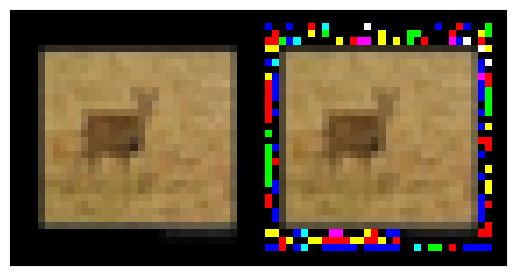

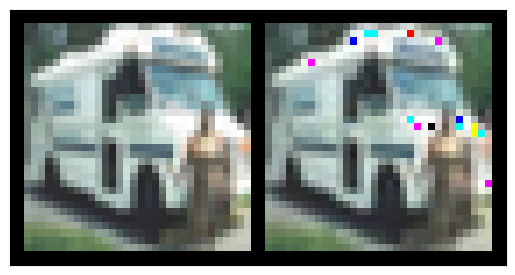

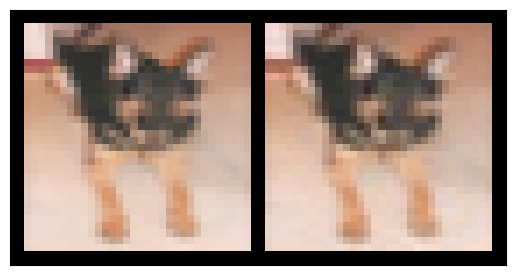

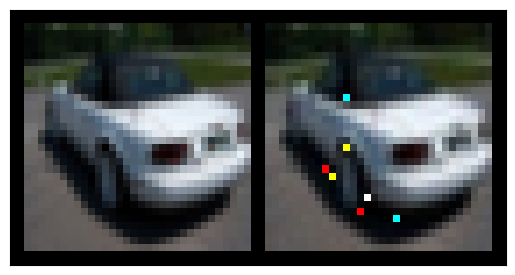

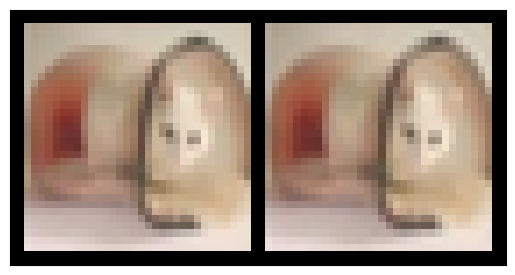

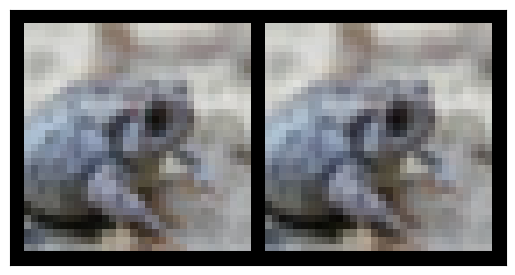

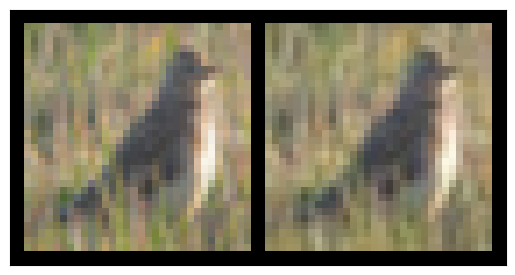

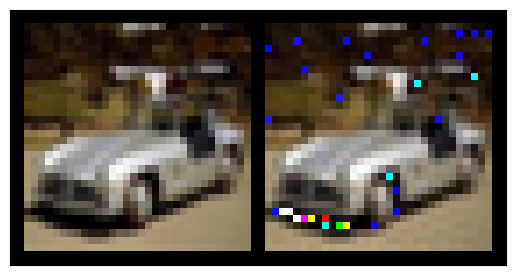

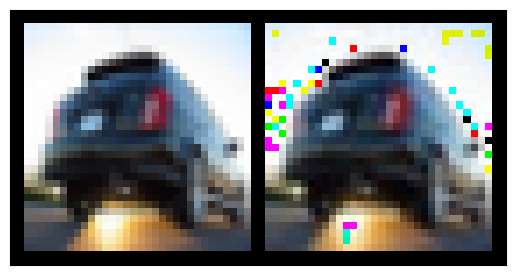

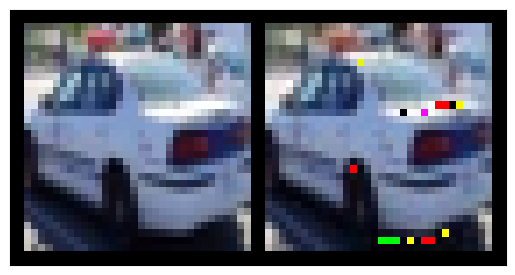

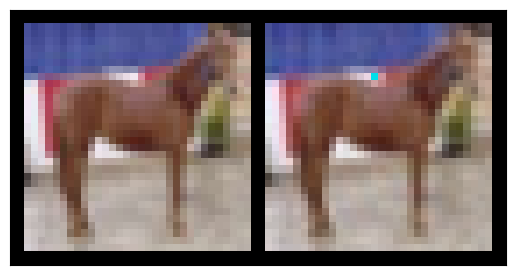

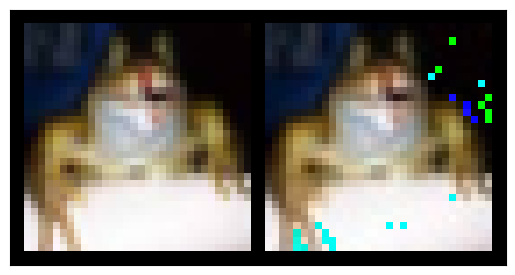

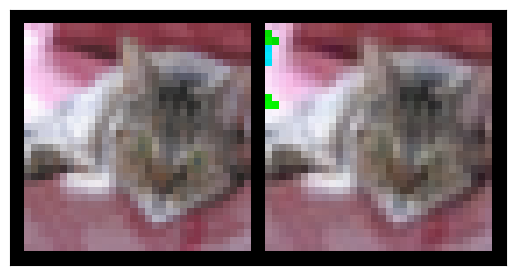

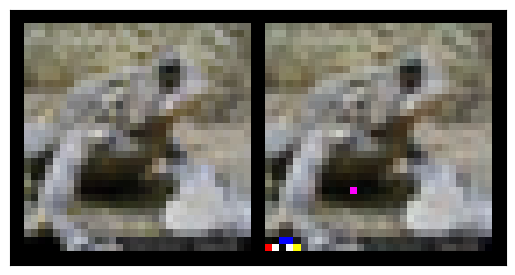

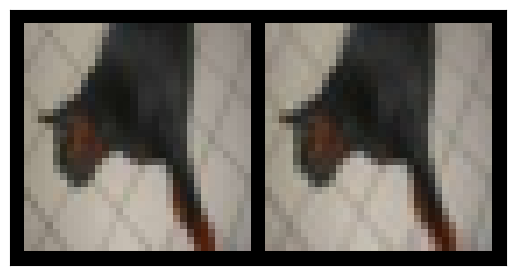

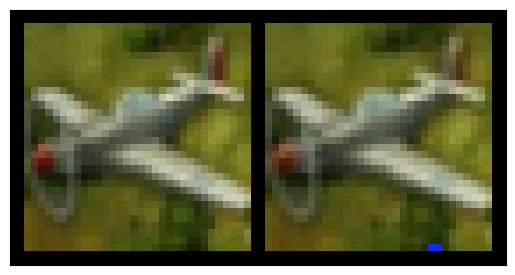

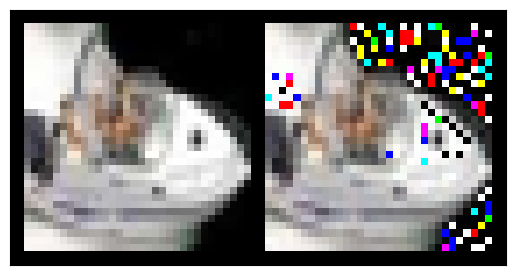

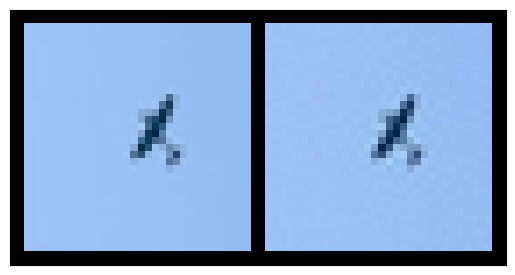

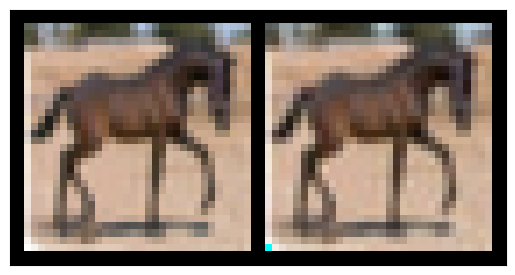

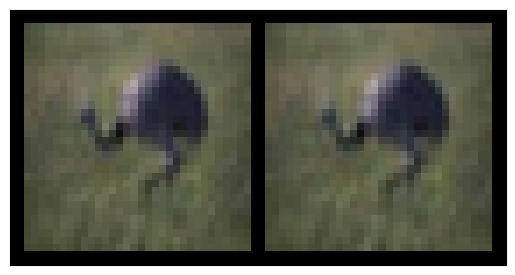

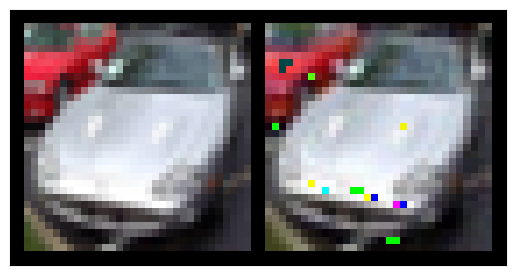

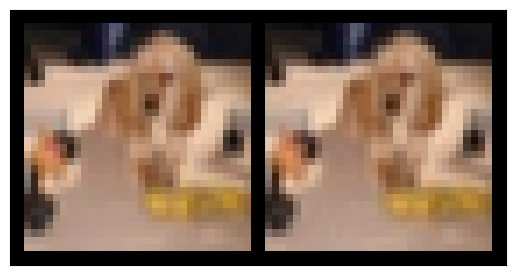

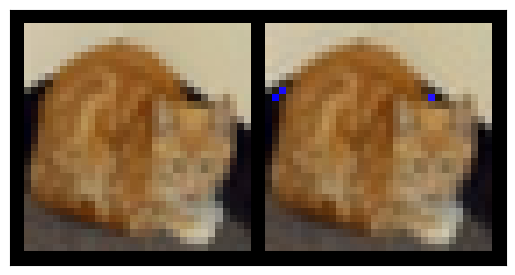

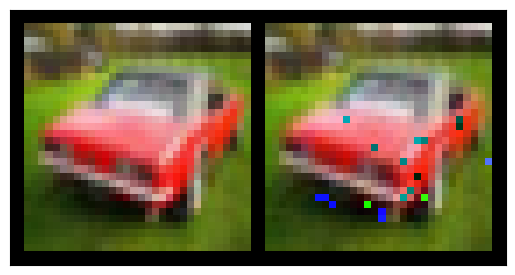

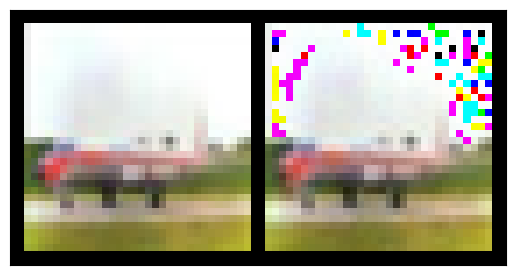

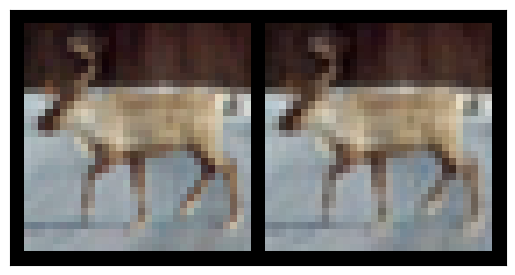

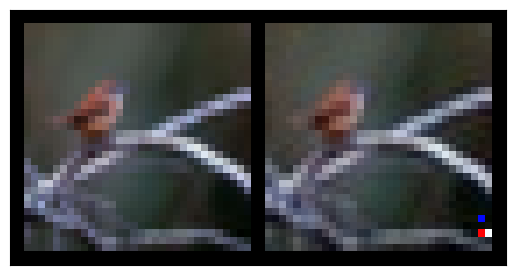

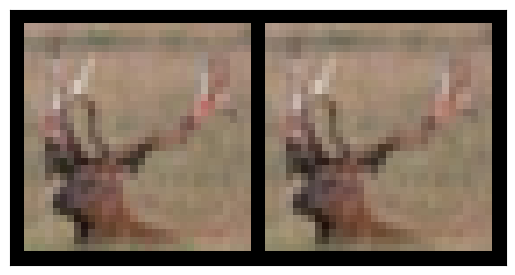

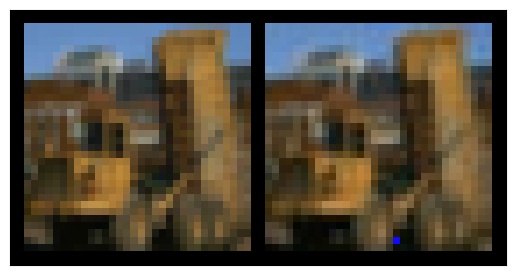

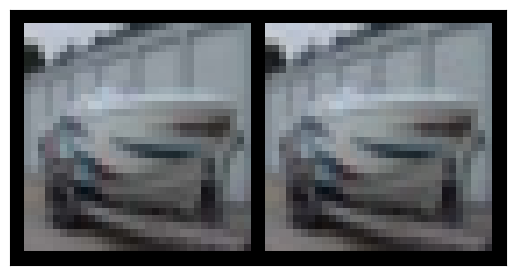

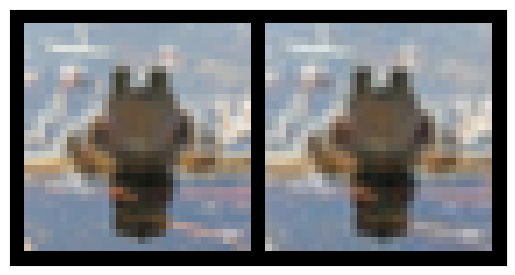

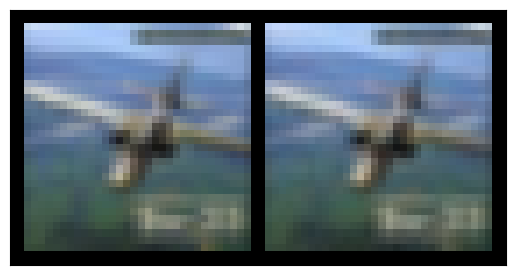

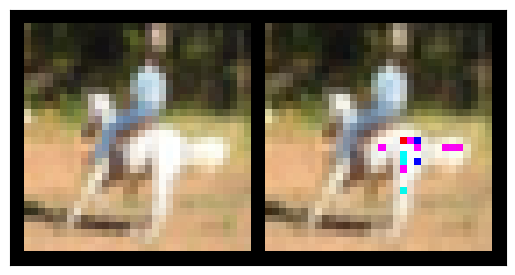

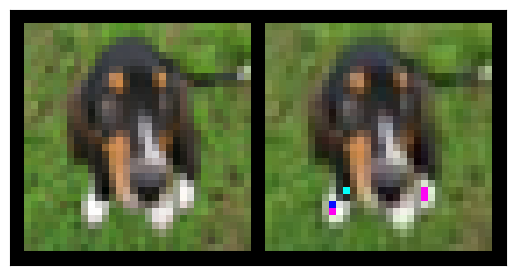

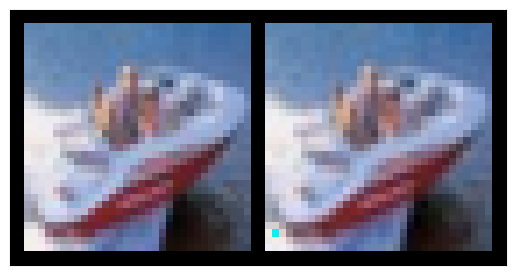

In [60]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        fig.show()
    return fig
#original=torch.Tensor(x_train)
#reconstructed=torch.from_numpy(reconstructed_image)
print (original.shape, reconstructed.shape)
for i in range(batch_size):
    img_list=[original[i],reconstructed[i]]
    grid = make_grid(img_list)
    show(grid)

In [84]:
bottleneck=3*6*6
dropout_percent=0
print(Decoder2(bottleneck=bottleneck,dropout_percent=dropout_percent))
#print(AutoEncoder(Encoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="modEncogDec"))
#print(AutoEncoder(Encoder(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="ogEncmodDec"))
#print(AutoEncoder(Encoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="modEncmodDec"))

Decoder2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (printL): PrintLayer()
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (dropout_relu): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): ReLU()
  )
  (linear_relu_stack): Sequential(
    (0): Unflatten(dim=1, unflattened_size=torch.Size([3, 6, 6]))
  )
  (conv_stack1): Sequential(
    (0): ConvTranspose2d(3, 15, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (conv_stack2): Sequential(
    (0): ConvTranspose2d(15, 32, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
  )
  (conv_stack3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
  )
  (output_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18000, out_features=3072, bias=True)
    (2): Sequential(
      (0): Dropout(p=0, inplace=False)
      (1): ReLU()
    )
    (3): Unflatten(dim=1, unflattened_size=torch.Size([3, 32, 32]))
  )
)


/tmp/ipykernel_3434395/1064816724.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = load("/home/i/ioakeime/Models/svms/Autoencoders/checkpoint_modEncmodDec.p

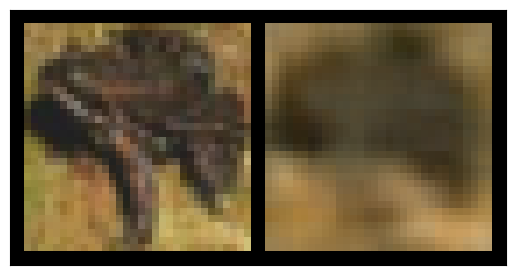

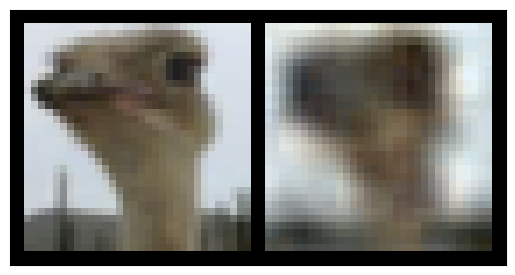

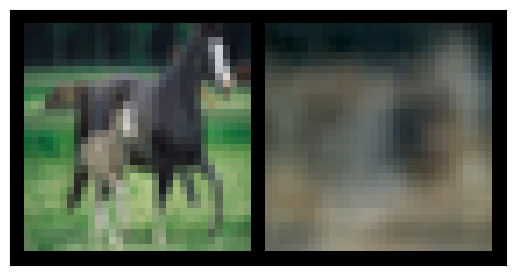

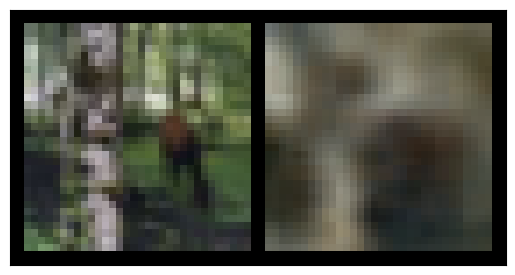

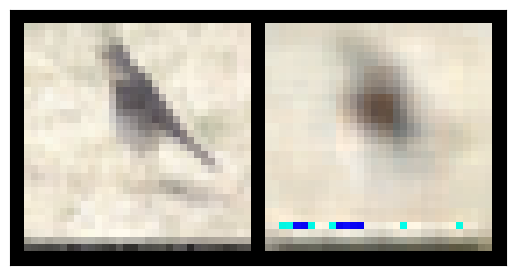

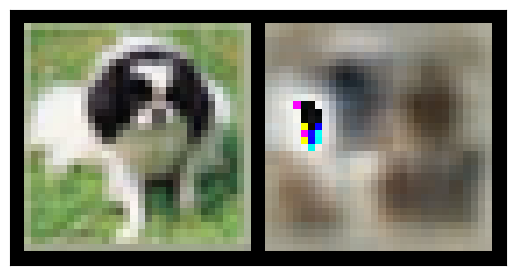

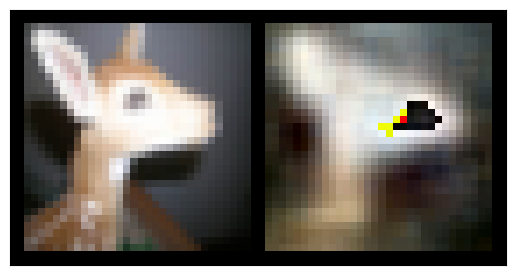

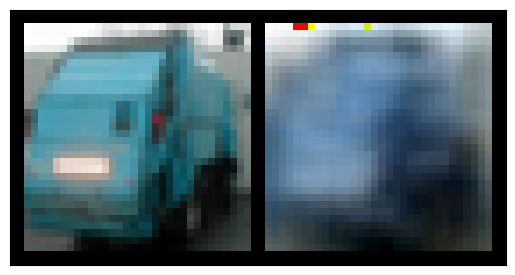

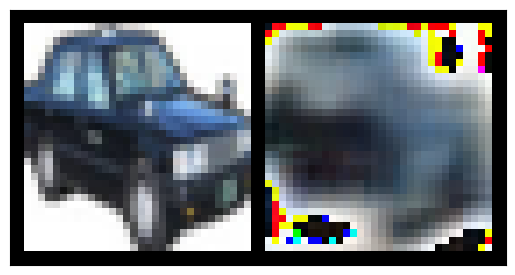

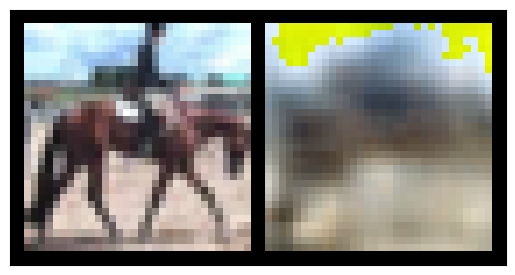

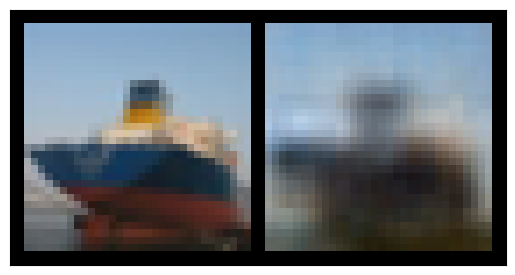

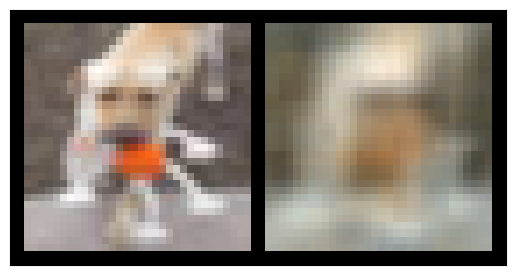

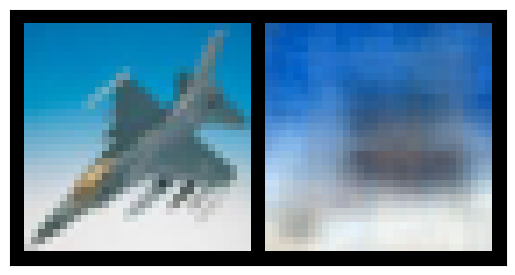

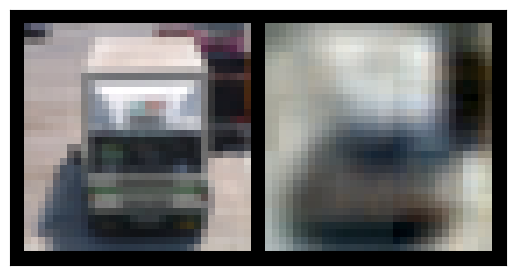

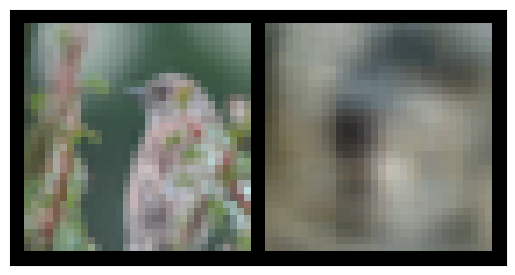

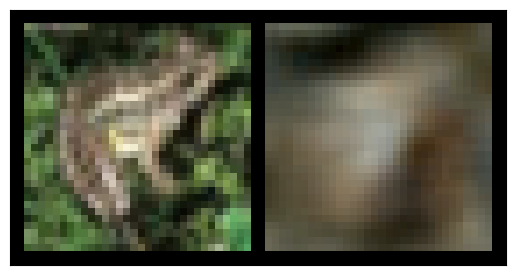

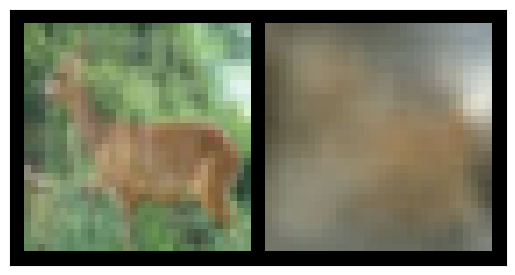

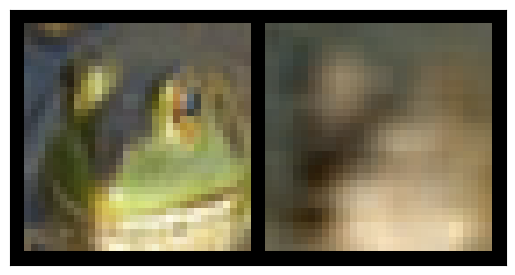

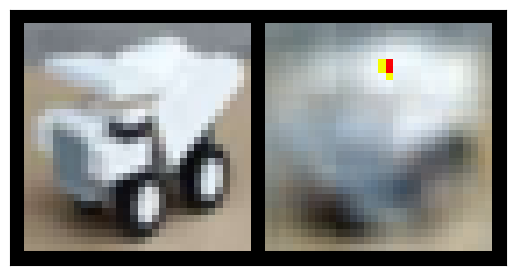

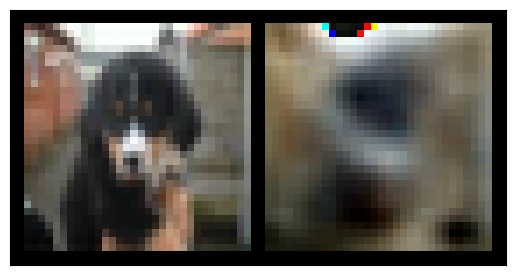

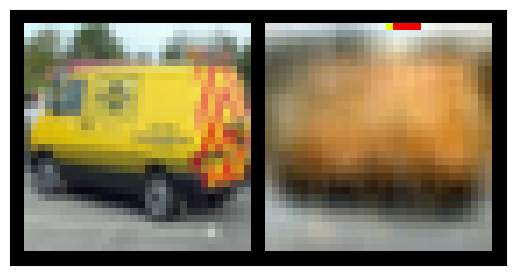

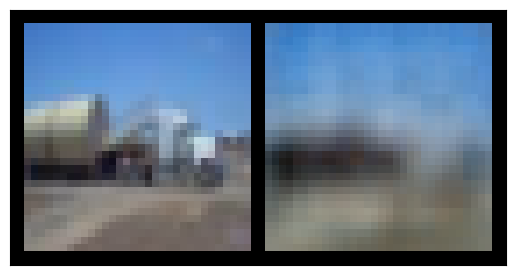

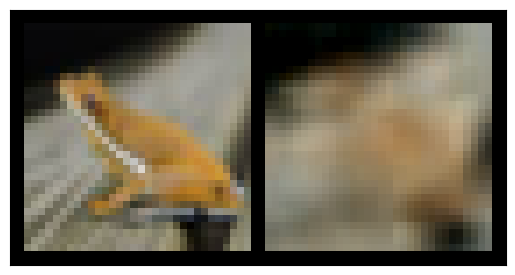

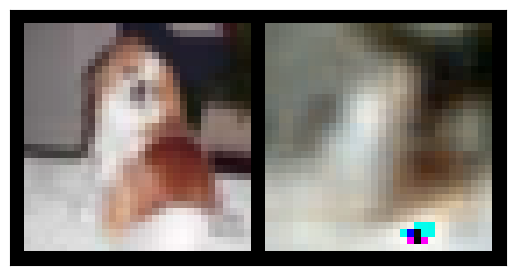

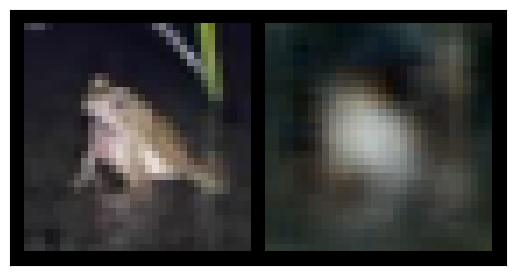

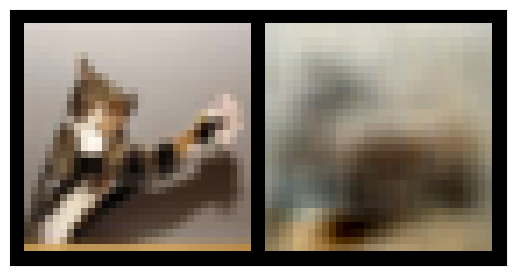

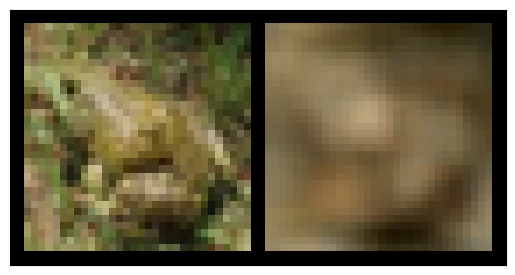

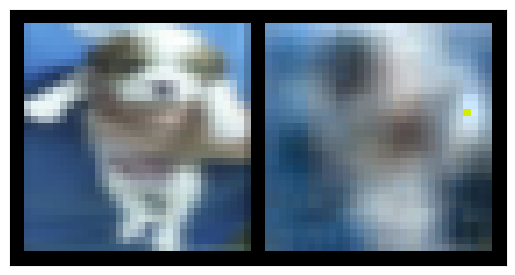

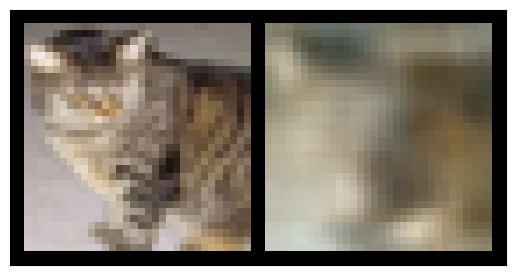

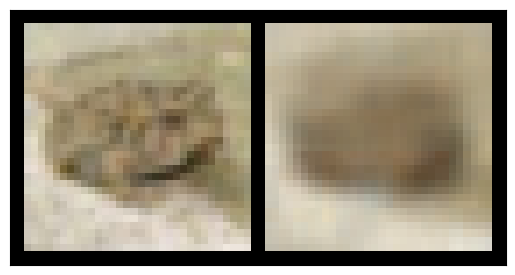

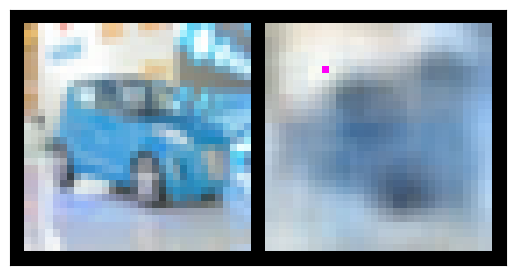

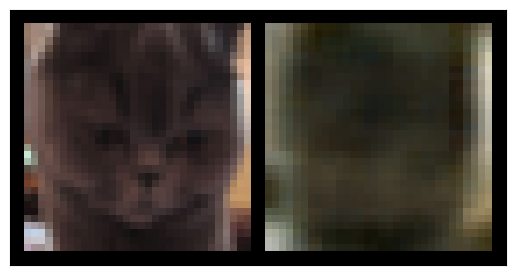

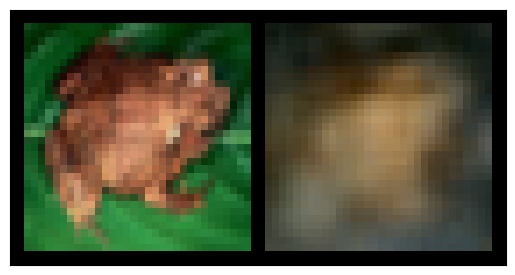

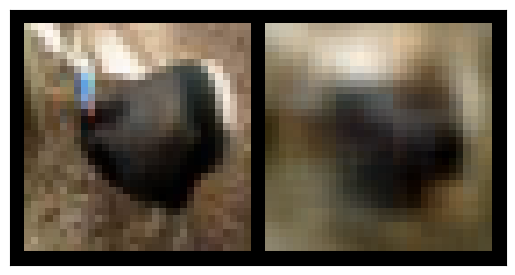

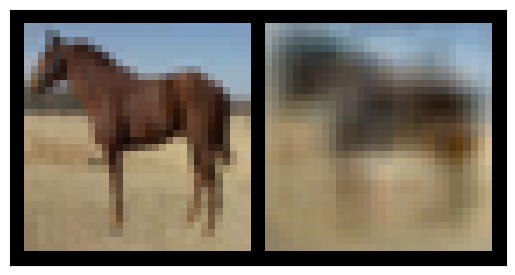

In [85]:
bottleneck=3*6*6
dropout_percent=0
model=AutoEncoder(Encoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),Decoder2(bottleneck=bottleneck,dropout_percent=dropout_percent),modelName="modEncmodDec")
model.to(device)
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        fig.show()
    return fig
checkpoint = load("/home/i/ioakeime/Models/svms/Autoencoders/checkpoint_modEncmodDec.pt", map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
with no_grad():
    for images, target_images in dataloader_train:
        images=images.to(device)
        target_images=target_images.to(device)
        #print(images[0].shape,target_images[0].shape
        for i in range(batch_size):
            img_list=[images[i],model(images)[i]]
            grid = make_grid(img_list)
            show(grid)
        break


In [ ]:
# Calculate the mean and std of the dataset for normalization
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in dataloader_train:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
#file=open("/Downloads/mean_std.txt","w")
print("Mean: "+str(mean)+"\n"+"Std: "+str(std))
#file.write("Mean: "+str(mean)+"\n"+"Std: "+str(std))
#file.close()

In [17]:
torch.cuda.mem_get_info(device)

(1265393664, 6442450944)